# 4. Improve Results

From https://machinelearningmastery.com/process-for-working-through-machine-learning-problems/

After spot checking, it’s time to squeeze out the best result from the rig. I do this by running an automated sensitivity analysis on the parameters of the top performing algorithms. I also design and run experiments using standard ensemble methods of the top performing algorithms. I put a lot of time into thinking about how to get more out of the dataset or of the family of algorithms that have been shown to perform well.

Again, statistical significance of results is critical here. It is so easy to focus on the methods and play with algorithm configurations. The results are only meaningful if they are significant and all configuration are already thought out and the experiments are executed in batch. I also like to maintain my own personal leaderboard of top results on a problem.

In summary, the process of improving results involves:

* Algorithm Tuning: where discovering the best models is treated like a search problem through model parameter space.
* Ensemble Methods: where the predictions made by multiple models are combined.
* Extreme Feature Engineering: where the attribute decomposition and aggregation seen in data preparation is pushed to the limits.


In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.cm import get_cmap
%matplotlib inline

 * [Training and submission data](#Training-and-submission-data)
 * [Model checking](#Model-checking)
   * [Linear regression](#Linear-regression)
   * [Plotting target indicator](#Plotting-target-indicator)
   * [Polynomial model setup (12/06/2019)](#Polynomial-model-setup-(12/06/2019))
      * [Polynomial regression baseline](#Polynomial-regression-baseline)
* [Using multivariate indicators](#Using-multivariate-indicators)
    * [Cross correlation](#Cross-correlation)
    * [VAR](#VAR)

## Training and submission data

In [2]:
df = pd.read_csv('data/TrainingSet.csv', index_col=0)
df.columns = [year[:4] for year in df.columns][:-3] + [col.replace(' ', '_') for col in df.columns.values[-3:]]

In [3]:
# read the data containing the rows we need to predict
df_submission = pd.read_csv('data/SubmissionRows.csv', index_col=0)

In [4]:
df_submission_in_data = df.loc[df_submission.index]
submission_codes = df_submission_in_data.Series_Code.unique()

## Model checking

 * We have 737 indicators from 206 countries with data from 1972 to 2007.
 * We would like to predict what these indicators will be in 2008 and 2012.

### Linear regression

A very simplistic way of predicting the future values of these indicators would be to do a simple linear regression for indicators with more than 1 data point in the last 35 years or use the only data point we have for indicators with a single value.

In [5]:
from sklearn.linear_model import LinearRegression

In [6]:
def make_prediction(row):
    data = row.loc['1972':'2007']
    nbr_data_points = data.count()
    if nbr_data_points < 2:
        pred_2008 = data.dropna().values
        pred_2012 = pred_2008
    
    else:
        years = data.dropna().index.values.astype(np.int).reshape(-1, 1)
        values = data.dropna().values
        
        # linear regression
        regr = LinearRegression()
        regr.fit(years, values)
        
        # predictions
        pred_2008 = regr.predict(np.array([2008]).reshape(-1, 1))
        pred_2012 = regr.predict(np.array([2012]).reshape(-1, 1))
        
    return pred_2008[0], pred_2012[0]

In [7]:
df_simple_preds = pd.DataFrame(df_submission_in_data.apply(make_prediction, axis=1).tolist(), \
                               index=df_submission_in_data.index, columns=['2008','2012'])

In [8]:
df_simple_preds.head()

,2008,2012
559,0.465706,0.580451
618,0.012712,0.016830
753,0.087664,0.065155
1030,0.001000,0.001000
1896,0.961802,0.960782


In [9]:
def plot_predictions(df_train, df_pred, nbr_rows):
    np.random.seed(3)
    rows_to_plot = np.random.choice(df_train.index.values, nbr_rows, replace=False)
    
    cmap = get_cmap('Set1')
    colors = cmap.colors
        
    fig, ax = plt.subplots(figsize=(16,10))
    for i,j in zip(rows_to_plot, range(nbr_rows)):
        if j >= len(colors): j -= len(colors)
        ax.plot(df_train.loc[i, '1972':'2007'].dropna().index.astype(int), 
                df_train.loc[i, '1972':'2007'].dropna().values, 
                label=df_train.loc[i, 'Country_Name']+ '/' + df_train.loc[i, 'Series_Name'],
                marker='o',
                linewidth=4,
                alpha=0.5,
                color=colors[j])
                
        ax.plot(df_pred.loc[i].index.astype(int), 
                df_pred.loc[i].values,
                marker='s',
                linewidth=4,
                markersize=10,
                color=colors[j])

    plt.legend(loc=2)

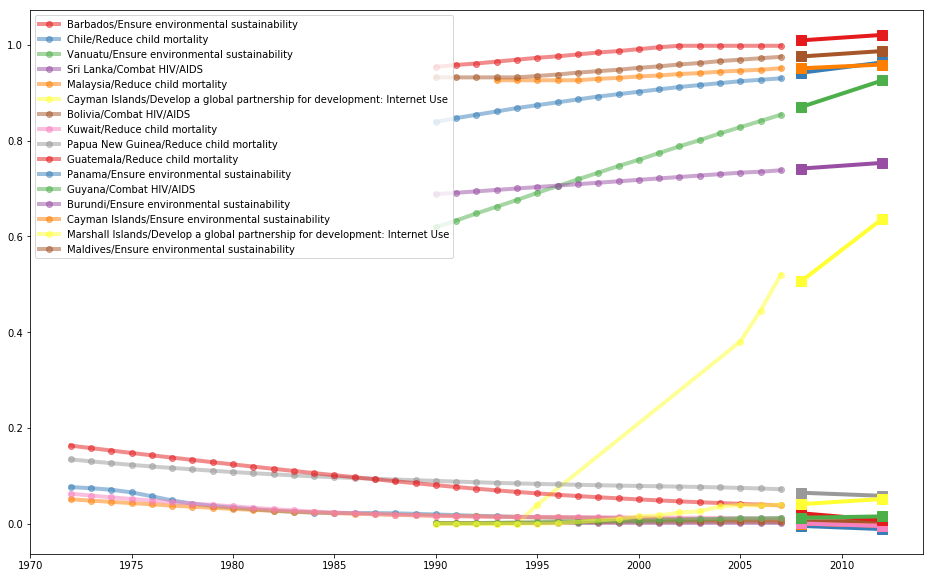

In [10]:
plot_predictions(df_submission_in_data, df_simple_preds, 16)

These results are simplistic but not too bad for most indicators. We could improve easily the results by doing a polynomial regression or another type of more sophisticated regression.  

What we are trying to achieve is to find a correlation between these indicators and all the other indicators present in the dataset, as to improve our predictions since we have a lot of missing data. These predictions using correlations are where the difficulty of this exercise lies.

### Plotting target indicator

#### Plotting one target indicator [Environmental Sustainability (7.8)] for Afghanistan

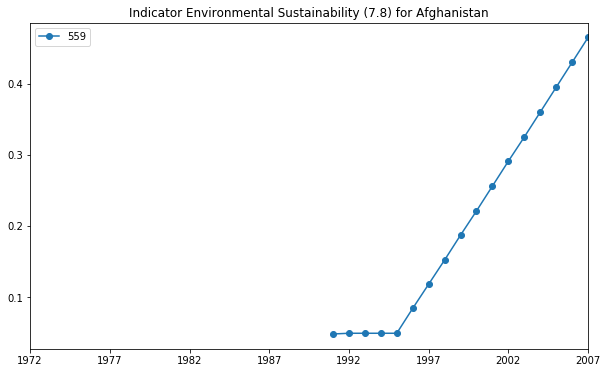

In [11]:
df_afghanistan_7_8 = df[ (df["Country_Name"] == "Afghanistan") & (df["Series_Code"] == "7.8")]
df_afghanistan_7_8_1972_to_2007 = df_afghanistan_7_8.loc[:, "1972":"2007"]
df_afghanistan_7_8_1972_to_2007.T.plot(marker="o", figsize=(10, 6), \
                                       title="Indicator Environmental Sustainability (7.8) for Afghanistan");

#### Plotting all indicators except Environmental Sustainability (7.8) for Afghanistan

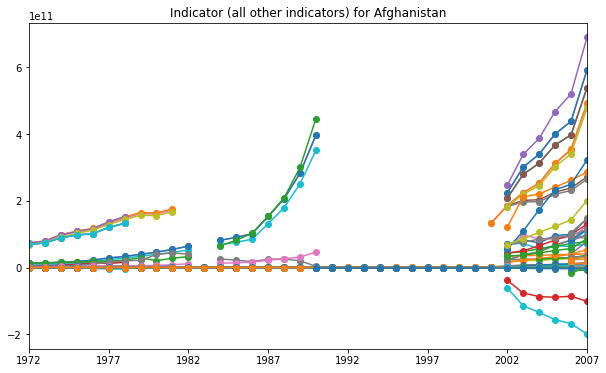

In [12]:
df_afghanistan_not_7_8 = df[ (df["Country_Name"] == "Afghanistan") & (df["Series_Code"] != "7.8")]
df_afghanistan_not_7_8_1972_to_2007 = df_afghanistan_not_7_8.loc[:, "1972":"2007"]
df_afghanistan_not_7_8_1972_to_2007.T.plot(marker="o", figsize=(10, 6), legend=False, \
                                           title="Indicator (all other indicators) for Afghanistan");

#### Plotting all indicators except Environmental Sustainability (7.8) for Afghanistan for 2001 to 2007

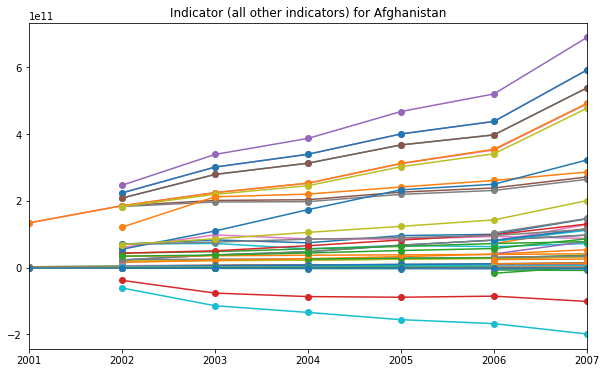

In [13]:
df_afghanistan_not_7_8 = df[ (df["Country_Name"] == "Afghanistan") & (df["Series_Code"] != "7.8")]
df_afghanistan_not_7_8_1972_to_2001 = df_afghanistan_not_7_8.loc[:, "2001":"2007"]
df_afghanistan_not_7_8_1972_to_2001.T.plot(marker="o", legend=False, figsize=(10, 6), \
                                           title="Indicator (all other indicators) for Afghanistan");

#### Enlisting top correlated features against target feature [Environmental Sustainability (7.8)]

In [14]:
df_afghanistan = df[ df["Country_Name"] == "Afghanistan" ]

df_2000_2007 = df_afghanistan.loc[:, "2000":"2007"]
df_2000_2007_clean_index = df_2000_2007.count(axis=1) >= 4

data = df_afghanistan[df_2000_2007_clean_index].set_index('Series_Code').loc[:, "2000":"2007"].T

coeff = data.corr().loc["7.8"].abs()
coeff.sort_values(inplace=True, ascending=False)
coeff.iloc[0:20]

Series_Code
7.8                  1.000000
SH.H2O.SAFE.UR.ZS    0.999991
SH.H2O.SAFE.RU.ZS    0.999980
SP.RUR.TOTL.ZS       0.999972
SP.URB.TOTL.IN.ZS    0.999972
SH.STA.ACSN.UR       0.999958
4.1                  0.999815
SP.DYN.IMRT.IN       0.999794
SP.URB.TOTL          0.999742
SH.STA.ACSN          0.999618
SH.DYN.NMRT          0.999542
SP.DYN.CDRT.IN       0.999375
SP.POP.TOTL          0.999343
EN.POP.DNST          0.999343
SL.TLF.TOTL.IN       0.999190
SP.DYN.LE00.FE.IN    0.999073
SP.DYN.AMRT.FE       0.999012
SP.RUR.TOTL          0.998992
SP.DYN.LE00.IN       0.998971
SP.DYN.AMRT.MA       0.998868
Name: 7.8, dtype: float64

#### Plotting the top correlated indicators for Afghanisthan between 2000 to 2007

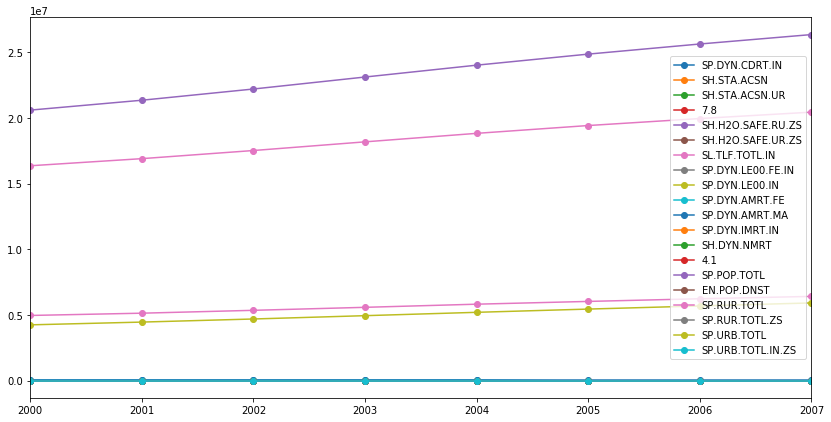

In [15]:
series_code_correlated_to_7_8 = coeff.iloc[0:20].index
df_afghanistan_indicators_correlated_to_7_8 = df_afghanistan[df_afghanistan.Series_Code.isin(series_code_correlated_to_7_8)]
df_afghanistan_indicators_correlated_to_7_8.set_index('Series_Code', inplace=True)
plt.rcParams["figure.figsize"] = (14,7)
df_afghanistan_indicators_correlated_to_7_8.loc[:, "2000":"2007"].T.plot(marker="o", legend=True)
plt.legend(loc=5);

In [16]:
from sklearn.preprocessing import normalize, scale, MinMaxScaler

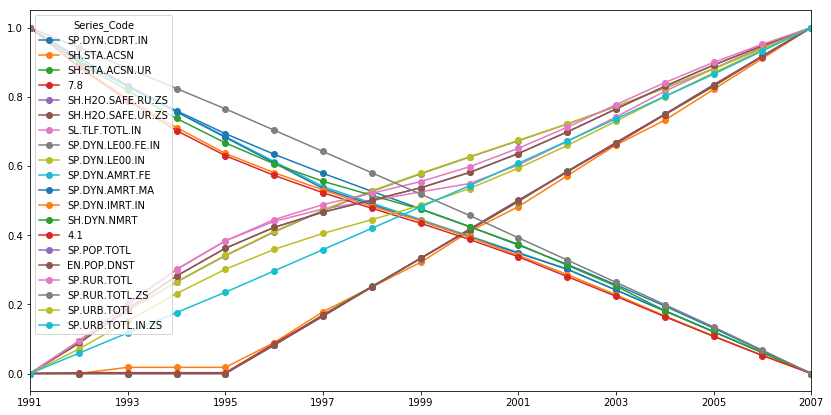

In [17]:
scaled_df = df_afghanistan_indicators_correlated_to_7_8.loc[:,'1972':'2007'].T
# print(scaled_df.shape)
# display(scaled_df.head(20))
scaled_df = scaled_df.dropna()
scaled2_norm_df = pd.DataFrame(normalize(scaled_df, axis=0), columns=scaled_df.columns, index=scaled_df.index)
scaled2_scale_df = pd.DataFrame(scale(scaled_df, axis=0), columns=scaled_df.columns, index=scaled_df.index)
scaled2_MinMax_df = pd.DataFrame(MinMaxScaler().fit_transform(scaled_df), columns=scaled_df.columns, index=scaled_df.index)
# display(scaled_df.head(20))
# scaled2_norm_df.plot(marker="o", legend=True)
# scaled2_scale_df.plot(marker="o", legend=True)
scaled2_MinMax_df.plot(marker="o", legend=True);

In [18]:
pred_columns = [str(item) + "_pred" for item in np.array(range(2002,2008))]
true_columns = [str(item) for item in range(2002,2008)]

In [19]:
def make_prediction(row):
    training_data = row.loc['1972':'2002']
    test_data = row.loc['2002':'2007']
    
    nbr_data_points = training_data.count()
    if test_data.count() < 6 or training_data.count() < 6 :
        return  [None]*6
    else:
        years = training_data.dropna().index.values.astype(np.int).reshape(-1, 1)
        values = training_data.dropna().values
        
        #linear regression
        regr = LinearRegression()
        regr.fit(years, values)
        
        #predictions
        return regr.predict(np.array(range(2002,2008)).reshape(-1, 1))

In [20]:
%pdb 0
from pdb import set_trace
from sklearn.metrics import mean_squared_error

Automatic pdb calling has been turned OFF


In [21]:
def count_nas(df):
    return df.isna().sum().sum()

In [22]:
df = df_submission_in_data.dropna(subset=true_columns)
df_simple_preds_true_columns = pd.DataFrame(df.apply(make_prediction, axis=1).tolist(), \
                               index=df.index, columns=true_columns)

In [23]:
df_simple_preds.shape

(737, 2)

In [24]:
df_simple_preds_true_columns.shape

(697, 6)

In [25]:
scaled_df.shape

(17, 20)

In [26]:
scaler = MinMaxScaler()
scaled_df_submission = df_submission_in_data.loc[:,'1972':'2007']
scaled_df_submission = scaled_df_submission.dropna()
scaled2_MinMax_df_submission = pd.DataFrame(scaler.fit_transform(scaled_df_submission), \
                                            columns=scaled_df_submission.columns, index=scaled_df_submission.index)

In [27]:
scaled2_MinMax_df_submission.shape

(148, 36)

In [28]:
scaled2_MinMax_df_dropna = scaled2_MinMax_df_submission.dropna(subset=true_columns)
scaled2_MinMax_df_preds = pd.DataFrame(scaled2_MinMax_df_dropna.apply(make_prediction, axis=1).tolist(), \
                               index=scaled2_MinMax_df_dropna.index, columns=true_columns)

In [29]:
scaled2_MinMax_df_true_columns = scaled2_MinMax_df_dropna[true_columns]
scaled2_MinMax_df_true_columns.shape

(148, 6)

In [30]:
scaled2_MinMax_df_preds.shape

(148, 6)

In [31]:
count_nas(scaled2_MinMax_df_true_columns)

0

In [32]:
scaled2_MinMax_df_true_columns.head(2)

,2002,2003,2004,2005,2006,2007
753,0.125452,0.121878,0.119000,0.115870,0.112646,0.109700
3427,0.027856,0.026145,0.024909,0.023618,0.022408,0.021496


In [33]:
count_nas(scaled2_MinMax_df_preds)

0

In [34]:
scaled2_MinMax_df_preds.head(2)

,2002,2003,2004,2005,2006,2007
753,0.108071,0.101877,0.095683,0.089488,0.083294,0.077099
3427,-0.014307,-0.021623,-0.028940,-0.036256,-0.043572,-0.050889


In [35]:
def assert_all_finite(X):
    X = np.asanyarray(X)
    return (X.dtype.char in np.typecodes['AllFloat'] and np.isfinite(X.sum())
            and np.isfinite(X).all())

In [36]:
def validate(y_true, y_pred):
    y_true_df = y_true.copy()
    y_pred_df = y_pred.dropna()
    validate = y_true_df.loc[y_pred_df.index][true_columns]
    assert(assert_all_finite(validate.dropna()))
    assert(assert_all_finite(y_pred_df))
    return mean_squared_error(validate.dropna(), y_pred_df)
# should return the dispersion of the errors as well

print(validate(scaled2_MinMax_df_true_columns, scaled2_MinMax_df_preds))

0.0003382664053419795


In [37]:
retained_columns = ['Country_Name', 'Series_Code', 'Series_Name']

In [38]:
df_submission_in_data_dropna = df_submission_in_data.dropna(subset=true_columns)

In [39]:
df_submission_in_data_no_years = df_submission_in_data_dropna[retained_columns]

In [40]:
df_merged = pd.merge(scaled2_MinMax_df_true_columns, df_submission_in_data_no_years, left_index=True, \
                     right_index=True, how='outer', suffixes=('',''))

In [41]:
df_merged.dropna(inplace=True)
df_merged.shape

(148, 9)

In [42]:
assert(df_submission_in_data.shape[0] == df_simple_preds.shape[0])

In [43]:
# plot_predictions(df_submission_in_data, df_simple_preds, 16)

In [44]:
assert(df_merged.shape[0] == scaled2_MinMax_df_preds.shape[0])

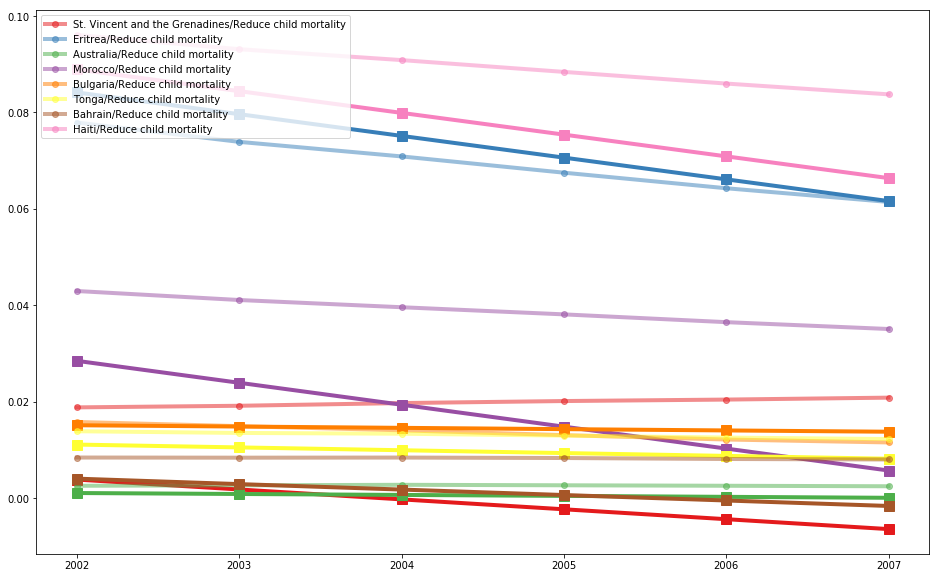

In [45]:
plot_predictions(df_merged, scaled2_MinMax_df_preds, 8)

### Polynomial model setup (12/06/2019)

In [46]:
# from sklearn.model_selection import train_test_split
# X = scaled2_norm_df
# print(X.shape)
# y = submission_codes
# print(y.shape)
# X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)

In [47]:
pred_columns = [str(item) + "_pred" for item in np.array(range(2002,2008))]
true_columns = [str(item) for item in range(2002,2008)]

In [48]:
def make_prediction(row, model):
    training_data = row.loc['1972':'2002']
    test_data = row.loc['2002':'2007']
    
    nbr_data_points = training_data.count()
    if test_data.count()<6 or training_data.count() < 6 :
        return  [None]*6
    else:
        years = training_data.dropna().index.values.astype(np.int).reshape(-1, 1)
        values = training_data.dropna().values
        
        model.fit(years, values)
        
        #predictions
        return model.predict(np.array(range(2002,2008)).reshape(-1, 1))

#### Polynomial regression baseline

In [49]:
pred_columns = [str(item) + "_pred" for item in np.array(range(2002,2008))]
true_columns = [str(item) for item in range(2002,2008)]

In [50]:
def make_prediction(row, model):
    training_data = row.loc['1972':'2002']
    test_data = row.loc['2002':'2007']
    
    nbr_data_points = training_data.count()
    if test_data.count()<6 or training_data.count() < 6 :
        return  [None]*6
    else:
        years = training_data.dropna().index.values.astype(np.int).reshape(-1, 1)
        values = training_data.dropna().values
        
        model.fit(years, values)
        
        #predictions
        return model.predict(np.array(range(2002,2008)).reshape(-1, 1))

In [51]:
from sklearn.preprocessing import PolynomialFeatures
from sklearn.pipeline import make_pipeline

In [52]:
model = LinearRegression()

In [53]:
df = df_submission_in_data.dropna(subset=true_columns)
# df.loc[:,'1972':'2007'].head()
df=df.loc[:,'2005':'2007']
df=df.iloc[0:2,:]
display(df.head())
transformer = PolynomialFeatures(degree=1)
df_poly=transformer.fit_transform(df.T)
print(df_poly)
transformer = PolynomialFeatures(degree=2,interaction_only=False)
df_poly=transformer.fit_transform(df.T)
print(df_poly)
transformer = PolynomialFeatures(degree=2,interaction_only=True)
df_poly=transformer.fit_transform(df.T)
print(df_poly)
# df_simple_preds_true_columns = pd.DataFrame(df.apply(make_prediction, args=(model,),axis=1).tolist(),\
#                                index=df.index, columns=true_columns)

,2005,2006,2007
559,0.395000,0.430000,0.465
618,0.012241,0.021071,0.019


[[1.         0.395      0.01224148]
 [1.         0.43       0.02107124]
 [1.         0.465      0.019     ]]
[[1.00000000e+00 3.95000000e-01 1.22414808e-02 1.56025000e-01
  4.83538493e-03 1.49853853e-04]
 [1.00000000e+00 4.30000000e-01 2.10712365e-02 1.84900000e-01
  9.06063168e-03 4.43997006e-04]
 [1.00000000e+00 4.65000000e-01 1.90000000e-02 2.16225000e-01
  8.83500000e-03 3.61000000e-04]]
[[1.         0.395      0.01224148 0.00483538]
 [1.         0.43       0.02107124 0.00906063]
 [1.         0.465      0.019      0.008835  ]]


In [54]:
model = make_pipeline(PolynomialFeatures(degree=2), LinearRegression())
# tried degree 3 but did not look better

In [55]:
scaler = MinMaxScaler()
scaled_df_submission = df_submission_in_data.loc[:,'1972':'2007']
scaled_df_submission = scaled_df_submission.dropna()
scaled_df_submission = scaled_df_submission.dropna(subset=true_columns)
scaled_df_submission = pd.DataFrame(scaler.fit_transform(scaled_df_submission), \
                                    columns=scaled_df_submission.columns, index=scaled_df_submission.index)

In [56]:
scaled_df_submission_preds = pd.DataFrame(scaled_df_submission.apply(make_prediction, args=(model,),axis=1).tolist(),\
                               index=scaled_df_submission.index, columns=true_columns)

In [57]:
print(validate(scaled_df_submission, scaled_df_submission_preds))

0.00026644798681812093


In [58]:
df_submission_in_data_dropna = df_submission_in_data.dropna(subset=true_columns)
df_submission_in_data_no_years = df_submission_in_data_dropna[retained_columns]
df_merged = pd.merge(scaled_df_submission, df_submission_in_data_no_years, left_index=True, \
                     right_index=True, how='outer', suffixes=('',''))
df_merged.dropna(subset=true_columns,inplace=True)

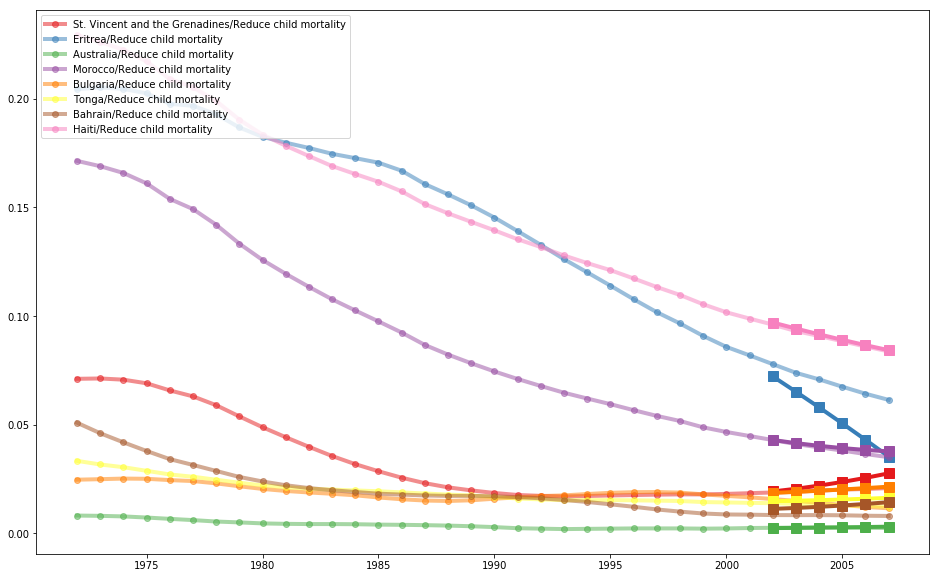

In [59]:
# df_merged = pd.merge(scaled_df_submission, df_submission_in_data_no_years, left_index=True, right_index=True, how='outer', suffixes=('',''))
plot_predictions(df_merged, scaled_df_submission_preds, 8)

## Using multivariate indicators
### Cross correlation

**Use cross correlation to find the relationship between delayed time series**

In [60]:
from scipy import signal

In [61]:
df = pd.read_csv('data/TrainingSet.csv', index_col=0)
df.columns = [year[:4] for year in df.columns][:-3] + [col.replace(' ', '_') for col in df.columns.values[-3:]]

In [62]:
# read the data containing the rows we need to predict
df_submission = pd.read_csv('data/SubmissionRows.csv', index_col=0)

In [63]:
df_submission_in_data = df.loc[df_submission.index]
submission_codes = df_submission_in_data.Series_Code.unique()

In [64]:
def cross_corr(country, seriesCode1, seriesCode2):
    df_country = df[df["Country_Name"] == country ]

    df_cross_corr_years = df_country.loc[:, "1972":"2007"]
    df_cross_corr_years_clean_index = df_cross_corr_years.count(axis=1) >= 20

    data = df_country[df_cross_corr_years_clean_index].set_index('Series_Code').loc[:, "1972":"2007"];
    sig = data[data.index == seriesCode1].values[0];
    sig_noise = data[data.index == seriesCode2].values[0];
    
    corr = signal.correlate(sig, sig_noise, mode='same')
    
    return (corr, sig_noise, sig, seriesCode1, seriesCode2);

/home/jeremie/.local/lib/python3.6/site-packages/matplotlib/figure.py:445: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  % get_backend())


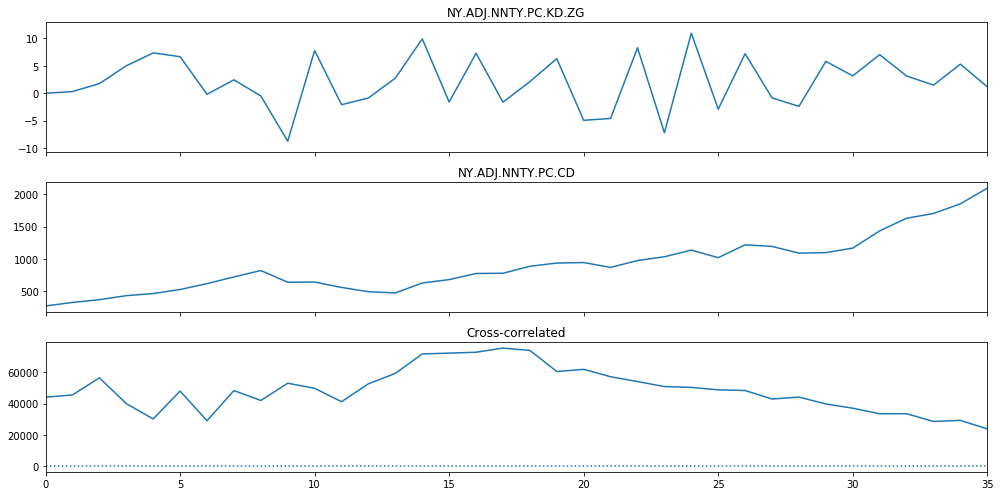

In [65]:
(corr, sig_noise, sig, seriesCode1, seriesCode2) = cross_corr('Morocco', 'NY.ADJ.NNTY.PC.KD.ZG', 'NY.ADJ.NNTY.PC.CD')

clock = np.arange(1972, 2008, 1)
fig, (ax_orig, ax_noise, ax_corr) = plt.subplots(3, 1, sharex=True)
ax_orig.plot(sig)
ax_orig.set_title(seriesCode1)
ax_noise.plot(sig_noise)
ax_noise.set_title(seriesCode2)
ax_corr.plot(corr)
ax_corr.axhline(0.5, ls=':')
ax_corr.set_title('Cross-correlated')
ax_orig.margins(0, 0.1)
fig.tight_layout()
fig.show()

### VAR

In [67]:
import statsmodels.api as sm

from statsmodels.tsa.api import VAR, DynamicVAR

model = VAR(data)

In [79]:
%pdb off

model = VAR(df_submission_in_data.loc[:,'1972':'2007'].T)
# failing
# results = model.fit(2)
# results.summary()

Automatic pdb calling has been turned OFF


/home/jeremie/.local/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency AS-JAN will be used.
  % freq, ValueWarning)
